In [1]:

# Idea:
# Get every edge into a dataframe to allow you to sort and assess
# Evaluate missing edge distances as well as correct edge distances to set relic threshold
# 100+ edges maybe incorrect because of forced inclusion - lets try to reduce that


In [2]:
from relic.graphs.graphs import get_precision_recall, draw_graph
import pandas as pd
import networkx as nx
import os
import glob
import numpy as np

In [4]:
#workflow_ids = ['real', '1','2','3','4','5','6']
#base_dir = '/home/suhail/Data/relic/mixed/grid'
#base_dir = '/mnt/roscoe/data/relic/single/'
#base_dir = '/mnt/roscoe/data/relic/mixed/mixed_sigmod/'
base_dir = '/mnt/roscoe/data/relic/mixed/mixed_sigmod_flat/'


wf_artifact_dict = {}
graph_dir = '/mnt/roscoe/data/relic/mixed/mixed_sigmod/real-world/combined/graphs/'

for g_file in glob.glob(graph_dir+"/*.pkl"):
    g_truth = nx.read_gpickle(g_file)
    for node in g_truth.nodes():
        wf_artifact_dict[node] = os.path.basename(g_file)
        
#wf_artifact_dict

def graph_compare(fset):
    u,v = fset
    return wf_artifact_dict[u] != wf_artifact_dict[v]


def split_compare(fset):
    x,y = fset
    return x.split('_')[0] != y.split('_')[0]

def get_edge_type_df(edge_list, gt_tag, inferred_tag, wf_id, config):
    return_df = pd.DataFrame(
        pd.Series(edge_list), columns=['edge'])
    return_df['ground_truth'] = gt_tag
    return_df['inferred'] = inferred_tag
    return_df['wf_id'] = wf_id
    return_df['config'] = config
    return return_df
    

def process_directory(base_dir, combined='combined'):
    workflow_ids = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    all_results = []
    edges_df = pd.DataFrame()
    for i in workflow_ids:
        gt_file = f"{base_dir}/{i}/{combined}/combined_gt_fixed.pkl"
        gt_graph = nx.read_gpickle(gt_file)
        print(f"Workflow {i}, Nodes: {len(gt_graph.nodes())}, Edges: {len(gt_graph.edges())}, Components {nx.number_connected_components(gt_graph.to_undirected())}")
        relic_results = f"{base_dir}/{i}/{combined}/inferred/*_inferred_graph.csv"
        for relic_result in glob.glob(relic_results):
            #print(relic_result)
            config = os.path.basename(relic_result).split('_')[0]
            inferred_graph = nx.read_edgelist(relic_result)
            result_dict = get_precision_recall(gt_graph, inferred_graph)
            
            this_edges_df = pd.DataFrame()
            this_edges_df = get_edge_type_df(list(result_dict['correct_edges']), True, True, i, config)
            this_edges_df = this_edges_df.append(get_edge_type_df(list(result_dict['to_add']), True, False, i, config), ignore_index=False)
            this_edges_df = this_edges_df.append(get_edge_type_df(list(result_dict['to_remove']), False, True, i, config), ignore_index=False)
            
            if i != 'real-world':
                this_edges_df['cross_workflow'] = this_edges_df['edge'].apply(lambda x: split_compare(x))
            else:
                #print(inferred_graph.nodes())
                this_edges_df['cross_workflow'] = this_edges_df['edge'].apply(lambda x: graph_compare(x))
                
            edges_df = edges_df.append(this_edges_df)
            result_dict.pop('correct_edges')
            result_dict.pop('to_add')
            result_dict.pop('to_remove')
            result_dict.update({
                'wf_id': i,
                'config': config,
                'artifacts': len(gt_graph.nodes()),
                'cross_workflow': this_edges_df['cross_workflow'].sum()
            })
            all_results.append(result_dict)
    

    return pd.DataFrame(all_results).sort_values('wf_id').reset_index(drop=True), edges_df.reset_index(drop=True)

    

In [5]:
r_df, edge_df = process_directory(base_dir)
r_df

Workflow 4, Nodes: 2127, Edges: 2027, Components 100
Workflow 3, Nodes: 2361, Edges: 2261, Components 100
Workflow 2, Nodes: 2331, Edges: 2231, Components 100
Workflow 1, Nodes: 2402, Edges: 2302, Components 100


,Precision,Recall,F1,wf_id,config,artifacts,cross_workflow
0,0.784257,0.817984,0.800765,1,relic,2402,3
1,0.801333,0.835795,0.818201,1,baseline,2402,184
2,0.782403,0.817122,0.799386,2,baseline,2331,184
3,0.784979,0.819812,0.802017,2,relic,2331,1
4,0.790254,0.824856,0.807185,3,relic,2361,11
5,0.788983,0.823529,0.805886,3,baseline,2361,202
6,0.770931,0.808584,0.789309,4,baseline,2127,201
7,0.785042,0.823384,0.803756,4,relic,2127,12


In [120]:
cf_edge = edge_df.groupby(['wf_id', 'config'])[['cross_workflow']].sum()
cf_edge 

cross_workflow
wf_id config                  
1     baseline             184
      relic                  3
2     baseline             184
      relic                  1
3     baseline             202
      relic                 11
4     baseline             201
      relic                 12

In [86]:
relic_results = r_df.loc[r_df.config == 'relic'].sort_values('wf_id').reset_index(drop=True)
relic_results

,Precision,Recall,F1,wf_id,config,artifacts,cross_workflow
0,0.853691,0.838313,0.845932,10,relic,2376,0
1,0.826779,0.821778,0.824271,11,relic,2249,2
2,0.823446,0.812355,0.817863,12,relic,2253,5
3,0.871351,0.856518,0.863870,9,relic,2156,0
4,0.957265,0.896000,0.925620,real-world,relic,135,0


In [164]:
# single_relic_config = relic_results.iloc[np.r_[14, 13, 1:4]].copy().reset_index(drop=True)
# single_relic_config['seed'] = np.repeat(25,5)
# single_relic_config['means'] = ['real_world', 0.1, 0.2, 0.5, 0.75]
# single_relic_config.at[0,'cross_workflow'] = 1
# single_relic_config

,Precision,Recall,F1,wf_id,config,artifacts,cross_workflow,seed,means
0,0.957265,0.896000,0.925620,real-world,relic,135,1,25,real_world
1,0.849536,0.845817,0.847672,9,relic,2156,9,25,0.1
2,0.829656,0.826011,0.827829,10,relic,2376,17,25,0.2
3,0.804418,0.813402,0.808885,11,relic,2249,41,25,0.5
4,0.787934,0.800743,0.794287,12,relic,2253,64,25,0.75


In [87]:
ar_df = r_df.loc[r_df.config.isin(['relic', 'baseline'])]
ar_df = ar_df.replace('relic', 'mnemosyne')
ar_df = ar_df.reset_index(drop=True)
ar_df = ar_df.reindex([8,9,6,7,0,1,3,2,5,4]).reset_index(drop=True)
ar_df['means'] = np.repeat(['real_world', 0.1, 0.2, 0.5, 0.75],2)
ar_df

,Precision,Recall,F1,wf_id,config,artifacts,cross_workflow,means
0,0.957265,0.896000,0.925620,real-world,mnemosyne,135,0,real_world
1,0.753731,0.808000,0.779923,real-world,baseline,135,15,real_world
2,0.871351,0.856518,0.863870,9,mnemosyne,2156,0,0.1
3,0.859861,0.901265,0.880076,9,baseline,2156,148,0.1
4,0.853691,0.838313,0.845932,10,mnemosyne,2376,0,0.2
5,0.866105,0.903779,0.884541,10,baseline,2376,154,0.2
6,0.826779,0.821778,0.824271,11,mnemosyne,2249,2,0.5
7,0.859875,0.899488,0.879236,11,baseline,2249,142,0.5
8,0.823446,0.812355,0.817863,12,mnemosyne,2253,5,0.75
9,0.848579,0.887599,0.867650,12,baseline,2253,163,0.75


In [102]:
ar_df.loc[ar_df.config=='mnemosyne'].F1.values
len(ar_df.index)

10

In [220]:
import matplotlib as mpl

def mergecells(table, cells):
    '''
    Merge N matplotlib.Table cells

    Parameters
    -----------
    table: matplotlib.Table
        the table
    cells: list[set]
        list of sets od the table coordinates
        - example: [(0,1), (0,0), (0,2)]

    Notes
    ------
    https://stackoverflow.com/a/53819765/12684122
    '''
    cells_array = [np.asarray(c) for c in cells]
    h = np.array([cells_array[i+1][0] - cells_array[i][0] for i in range(len(cells_array) - 1)])
    v = np.array([cells_array[i+1][1] - cells_array[i][1] for i in range(len(cells_array) - 1)])

    # if it's a horizontal merge, all values for `h` are 0
    if not np.any(h):
        # sort by horizontal coord
        cells = np.array(sorted(list(cells), key=lambda v: v[1]))
        edges = ['BTL'] + ['BT' for i in range(len(cells) - 2)] + ['BTR']
    elif not np.any(v):
        cells = np.array(sorted(list(cells), key=lambda h: h[0]))
        edges = ['TRL'] + ['RL' for i in range(len(cells) - 2)] + ['BRL']
    else:
        raise ValueError("Only horizontal and vertical merges allowed")

    for cell, e in zip(cells, edges):
        table[cell[0], cell[1]].visible_edges = e
        table[cell[0], cell[1]].set_facecolor('white')
        print(table[cell[0], cell[1]].)
        table[cell[0], cell[1]].set_text_props(clip_box=None, clip_on=False, clip_path=None)     
        
        
    txts = [table[cell[0], cell[1]].get_text() for cell in cells]
    tpos = [np.array(t.get_position()) for t in txts]

    # transpose the text of the left cell
    trans = (tpos[-1] - tpos[0])/2
    
    # didn't had to check for ha because I only want ha='center'
    txts[0].set_clip_on(False)
    txts[0].set_transform(mpl.transforms.Affine2D().translate(*trans))
    #print(txts[0], txts[0].get_clip_on())
    txts[0].set_visible(True)
    
    for txt in txts[1:]:
        txt.set_visible(False)

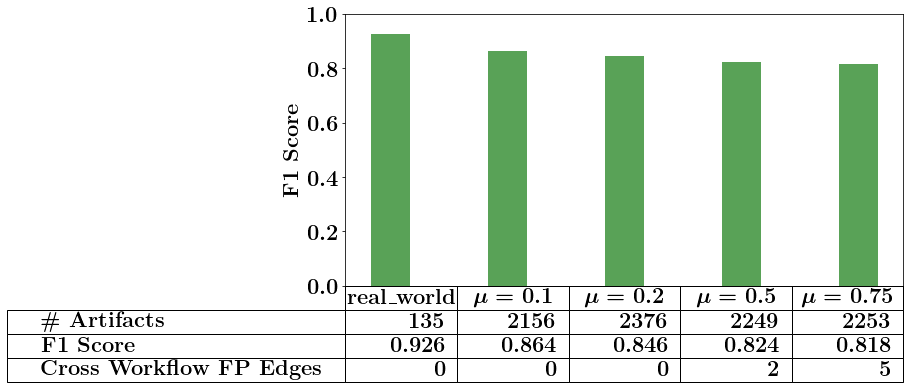

In [104]:
# Use Seaborn
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['text.usetex'] = True
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'

x = np.arange(len(ar_df.index)/2)*3  # the label locations
width = 1.0  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, ar_df.loc[ar_df.config=='mnemosyne'].F1.values, width, label='mnemosyne', color='#59A257')
#rects2 = ax.bar(x + width/2, ar_df.loc[ar_df.config=='baseline'].F1.values, width, label='baseline', color='#905998')

#ax.legend(loc='lower right', framealpha=1.0, labels=[r'\textbf{mnemosyne}', r'\textbf{baseline}'])

plt.ylabel(r'\textbf{F1 Score}')
plt.tick_params( axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylim(0.0,1.0)
table_df = ar_df.loc[ar_df.config=='mnemosyne'].round(3).transpose().reindex(['artifacts', 'F1', 'cross_workflow'])
table_df.index = [r'\textbf{\# Artifacts}', r'\textbf{F1 Score}', r'\textbf{Cross Workflow FP Edges}']
columns = [r'\textbf{real\_world}', r'$\mu=0.1$', r'$\mu=0.2$', r'$\mu=0.5$', r'$\mu=0.75$']
table_df.columns = columns
#table_df.columns = np.repeat(columns,2)
#table_df.index.name = None
#table_df

# header = plt.table(cellText=[['']*len(columns)],
#                       colLabels=columns,
#                       loc='bottom'
#                       )

# header.auto_set_font_size(False)
# header.set_fontsize(22)
# header.scale(1,2.5)

# header2_columns = np.unique(table_df.applymap(lambda x: f"${str(x)}$").iloc[0].values).tolist()
# header2 = plt.table(cellText=[header2_columns],
#                       rowLabels=[r'\textbf{\# Artifacts}'],
#                       loc='bottom',
#                       cellLoc='center',
#                       bbox=[0,-0.4,1.0,0.3],
#                       )

# header2.auto_set_font_size(False)
# header2.set_fontsize(22)
# header2.scale(1,1.5)

final_table_df = table_df#.iloc[1:]
final_table_df = final_table_df.applymap(lambda x: f"${str(x)}$")
xtable = plt.table(cellText=final_table_df.to_numpy(), rowLabels=final_table_df.index, 
                   colLabels=table_df.columns,
                   loc='bottom')
                   #bbox=[0, -0.4, 1.0, 0.3])
xtable.auto_set_font_size(False)

xtable.set_fontsize(22)
xtable.scale(1, 2)

plt.draw()


plt.savefig("mutiwf.pdf", bbox_inches='tight')

In [7]:
edge_df.groupby(['wf_id', 'config']).count()

edge  ground_truth  inferred  cross_workflow
wf_id config                                                
1     baseline  2779          2779      2779            2779
      relic     2820          2820      2820            2820
2     baseline  2738          2738      2738            2738
      relic     2732          2732      2732            2732
3     baseline  2759          2759      2759            2759
      relic     2756          2756      2756            2756
4     baseline  2514          2514      2514            2514
      relic     2484          2484      2484            2484

In [86]:
ar_df
table_df = ar_df.round(2).transpose().reindex(['artifacts', 'F1', 'cross_workflow'])
table_df.index = ['\# Artifacts', 'Mnemosyne F1 Score', 'FP Cross Workflow Edges']
table_df.columns = np.repeat(['real\_world', r'$\mu=0.1$', r'$\mu=0.2$', r'$\mu=0.5$', r'$\mu=0.75$'],2)
table_df

,real\_world,real\_world,$\mu=0.1$,$\mu=0.1$,$\mu=0.2$,$\mu=0.2$,$\mu=0.5$,$\mu=0.5$,$\mu=0.75$,$\mu=0.75$
\# Artifacts,135,135,2156,2156,2376,2376,2249,2249,2253,2253
Mnemosyne F1 Score,0.93,0.78,0.85,0.88,0.83,0.88,0.81,0.88,0.79,0.87
FP Cross Workflow Edges,0,15,9,148,17,154,41,142,64,163


In [247]:
 #.flatten().tolist()

[135, 2156, 2249, 2253, 2376]

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['text.usetex'] = True
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

mp_green = '#2ca02c'
mp_red = '#d62728'
ar_df = single_relic_config.set_index('means')
colors = [mp_red, mp_green, mp_green, mp_green, mp_green]
#ar_df.index.name = 'Data Lake'
ar_df.F1.plot.bar(color=colors, figsize=(7,4))
plt.ylabel('F1 Score')
plt.xlabel('')
plt.tick_params( axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylim(0.0,1.0)
table_df = ar_df.round(2).transpose().drop(['wf_id', 'config','seed']).reindex(['artifacts', 'F1', 'cross_workflow'])
table_df.index = ['\# Artifacts', 'Relic F1 Score', 'Cross Workflow Edges']
table_df.columns = ['real\_world', r'$\mu=0.1$', r'$\mu=0.2$', r'$\mu=0.5$', r'$\mu=0.75$']
#table_df.index.name = None
#table_df
xtable = plt.table(cellText=table_df.to_numpy(), rowLabels=table_df.index, colLabels=table_df.columns)
xtable.auto_set_font_size(False)

xtable.set_fontsize(18)
xtable.scale(1, 1.5)
#xtable.scale()
plt.savefig("mutiwf.pdf", bbox_inches='tight')

In [180]:
table_df = ar_df.round(2).transpose().drop(['wf_id', 'config','seed']).reindex(['artifacts', 'F1', 'cross_workflow'])
table_df.index = ['# Artifacts', 'Relic F1 Score', 'Cross Workflow Edges']
table_df.index.name = None
table_df.columns = ['real_world', r'\mu=0.1', r'\mu=0.2', r'\mu=0.5', r'\mu=0.75']
table_df

,real_world,\mu=0.1,\mu=0.2,\mu=0.5,\mu=0.75
# Artifacts,135,2156,2376,2249,2253
Relic F1 Score,0.93,0.85,0.83,0.81,0.79
Cross Workflow Edges,1,9,17,41,64


In [17]:
# Real Workflows cross-edge computation


{'y.csv': 'churn_gt_fixed.pkl',
 'churn_result.csv': 'churn_gt_fixed.pkl',
 'X.csv': 'churn_gt_fixed.pkl',
 'churn_feat_space.csv': 'churn_gt_fixed.pkl',
 'churn_df.csv': 'churn_gt_fixed.pkl',
 'churn_feat_space_bool.csv': 'churn_gt_fixed.pkl',
 'crimes.csv': 'london-crime_gt_fixed.pkl',
 'crimesByMonth.csv': 'london-crime_gt_fixed.pkl',
 'crimesByMonth__1.csv': 'london-crime_gt_fixed.pkl',
 'crimesByMonth__2.csv': 'london-crime_gt_fixed.pkl',
 'areaCrime.csv': 'london-crime_gt_fixed.pkl',
 'areaCrime__1.csv': 'london-crime_gt_fixed.pkl',
 'areaCrime__2.csv': 'london-crime_gt_fixed.pkl',
 'crimeTypes.csv': 'london-crime_gt_fixed.pkl',
 'typeLoc.csv': 'london-crime_gt_fixed.pkl',
 'locationRecode__1.csv': 'london-crime_gt_fixed.pkl',
 'typeLoc__1.csv': 'london-crime_gt_fixed.pkl',
 'typeLoc__2.csv': 'london-crime_gt_fixed.pkl',
 'typeLoc__3.csv': 'london-crime_gt_fixed.pkl',
 'crimes__2.csv': 'london-crime_gt_fixed.pkl',
 'typeOutcome.csv': 'london-crime_gt_fixed.pkl',
 'typeOutcome__1.

In [15]:
!ls /tank/local/suhail/data/relic/mixed/mixed_sigmod/real-world/combined/graphs/

ls: cannot access '/tank/local/suhail/data/relic/mixed/mixed_sigmod/real-world/combined/graphs/': No such file or directory


In [8]:
edge_df

,edge,ground_truth,inferred,wf_id,config,cross_workflow
0,"(91_005.csv, 91_000.csv)",True,True,4,baseline,False
1,"(66_007.csv, 66_018.csv)",True,True,4,baseline,False
2,"(25_029.csv, 25_013.csv)",True,True,4,baseline,False
3,"(21_013.csv, 21_002.csv)",True,True,4,baseline,False
4,"(18_002.csv, 18_001.csv)",True,True,4,baseline,False
...,...,...,...,...,...,...
21577,"(92_006.csv, 92_016.csv)",False,True,1,baseline,False
21578,"(42_006.csv, 42_017.csv)",False,True,1,baseline,False
21579,"(99_013.csv, 99_002.csv)",False,True,1,baseline,False
21580,"(50_019.csv, 50_028.csv)",False,True,1,baseline,False


In [ ]:
edge_df

In [41]:
check_edge = frozenset(['045.csv', '026.csv'])
ppo_df = pd.read_csv(f"{base_dir}/1/inferred/ppo.csv", index_col=0)
ppo_df['edge'] = ppo_df.apply(lambda x: frozenset([x['df1'], x['df2']]), axis=1)
ppo_df.loc[ppo_df.edge == check_edge]

,df1,df2,jaccard,containment,overlap,containment_oneside,edge
6,026.csv,045.csv,0.888889,1.0,73776.0,0.888889,"(026.csv, 045.csv)"


In [48]:
edge_df.loc[edge_df.edge == check_edge]

,edge,ground_truth,inferred,wf_id,config
11,"(026.csv, 045.csv)",True,True,1,cell+detectors
64,"(026.csv, 045.csv)",True,True,1,relic
117,"(026.csv, 045.csv)",True,True,1,baseline
171,"(026.csv, 045.csv)",True,True,1,cell


In [49]:
gt_file = f"{base_dir}/1/1_gt_fixed.pkl"
gt_graph = nx.read_gpickle(gt_file)
gt_graph.edges(data=True)

OutEdgeDataView([('000.csv', '001.csv', {'operation': 'point_edit', 'col': '3L27o_name_male', 'old_value': 'William Rogers', 'new_value': 'John Krueger'}), ('000.csv', '003.csv', {'operation': 'assign_string', 'col': 'E1W5S_time', 'new_col_name': 'E1W5S_time__swapcase'}), ('000.csv', '015.csv', {'operation': 'point_edit', 'col': 'GCzzA_pystr', 'old_value': 'ZhEacwlzSwikuZrqonBA', 'new_value': 'evKLLQOpHZHEiUDiWVkv'}), ('001.csv', '002.csv', {'operation': 'sample', 'frac': 0.69}), ('001.csv', '007.csv', {'operation': 'sample', 'frac': 0.77}), ('001.csv', '008.csv', {'operation': 'dropcol', 'col': 'Fyzio_currency_name'}), ('001.csv', '009.csv', {'operation': 'sample', 'frac': 0.18}), ('002.csv', '017.csv', {'operation': 'dropcol', 'col': 'ECJ3L_chrome'}), ('003.csv', '005.csv', {'operation': 'merge', 'on': 'FJI4m_free_email'}), ('003.csv', '006.csv', {'operation': 'dropcol', 'col': 'aIRTk_free_email'}), ('003.csv', '016.csv', {'operation': 'point_edit', 'col': 'KNrkH_time', 'old_value': 

In [85]:
r_df.groupby('config').mean().drop('wf_id',axis=1)

,Precision,Recall,F1
config,,,
baseline,0.859338,0.898803,0.878627
cell,0.810281,0.847495,0.828470
cell+detectors,0.767575,0.802828,0.784805
relic,0.821024,0.822288,0.821638


In [60]:
# Generate heatmap
seeds = [5, 10, 25, 50]
means = [0.1, 0.2, 0.5, 0.75]
configs = set(r_df.config.values)

#r_df['seeds'] = np.repeat(seeds, len(means) * len (configs))
#|r_df['means'] = np.tile(means, len(seeds) * len (configs))

In [61]:
from matplotlib import pyplot as plt

ar_df = pd.DataFrame(all_results)
ar_df.index = pd.Series(['real_world', '0', '0.1', '0.2', '0.4', '0.8','0.9' ])
colors = ['red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']
ar_df.index.name = 'Mean Overlap'
ar_df
ar_df.F1.plot.bar(color=colors)
plt.ylabel('F1 Score')
plt.savefig("mutiwf.pdf", bbox_inches='tight')

NameError: name 'all_results' is not defined

In [84]:
result_df = result_df.reset_index(drop=True)
result_df

NameError: name 'result_df' is not defined

In [9]:
from tqdm.auto import tqdm

# add graph information to the dataframe
def add_graph_info(base_dir, result_df, combined='combined'):
    previous_wf_id = None
    previous_config = None
    for ix, row in tqdm(result_df.iterrows()):
        wf_id = row['wf_id']
        config = row['config']
        if wf_id != previous_wf_id:
            gt_file = f"{base_dir}/{wf_id}/{combined}/combined_gt_fixed.pkl"
            gt_graph = nx.read_gpickle(gt_file).to_undirected()
            previous_wf_id = wf_id
            previous_config = None
        
        if config != previous_config:
            relic_result = f"{base_dir}/{wf_id}/{combined}/inferred/{config}_inferred_graph.csv"
            inferred_graph = nx.read_edgelist(relic_result)
            previous_config = config

        u,v = row['edge']
        if row['ground_truth']:
            result_df.at[ix, 'operation'] = gt_graph[u][v]['operation']
        if row['inferred']:
            result_df.at[ix, 'type'] = inferred_graph[u][v]['type']
            result_df.at[ix, 'score'] = inferred_graph[u][v]['weight']
            result_df.at[ix, 'num'] = inferred_graph[u][v]['num']
    
    return result_df

edge_df = edge_df.sort_values(['wf_id', 'config'])
edge_df = add_graph_info(base_dir, edge_df)
edge_df
#result_df=result_df.loc[result_df.wf_id.isin(['1','2','3'])]

0it [00:00, ?it/s]

,edge,ground_truth,inferred,wf_id,config,cross_workflow,operation,type,score,num
18803,"(37_003.csv, 37_006.csv)",True,True,1,baseline,False,merge,baseline,0.866667,1402.0
18804,"(30_024.csv, 30_007.csv)",True,True,1,baseline,False,merge,baseline,0.875000,1352.0
18805,"(24_002.csv, 24_011.csv)",True,True,1,baseline,False,point_edit,baseline,0.994048,320.0
18806,"(55_040.csv, 55_032.csv)",True,True,1,baseline,False,merge,baseline,0.625000,1782.0
18807,"(14_013.csv, 14_007.csv)",True,True,1,baseline,False,point_edit,baseline,0.928571,976.0
...,...,...,...,...,...,...,...,...,...,...
4993,"(13_003.csv, 13_006.csv)",False,True,4,relic,False,NaN,jaccard,0.666667,1742.0
4994,"(88_013.csv, 88_002.csv)",False,True,4,relic,False,NaN,jaccard,0.464286,501.0
4995,"(74_019.csv, 74_007.csv)",False,True,4,relic,False,NaN,jaccard,0.367800,581.0
4996,"(87_013.csv, 87_000.csv)",False,True,4,relic,False,NaN,jaccard,0.694600,355.0


In [73]:
#r_df.to_csv('grid_result_before_join_fix.csv')
#edge_df.to_csv('grid_edge_result_before_join_fix.csv')

In [11]:
wf_sel = (edge_df.wf_id == '1')
config_sel = (edge_df.config == 'relic')
type_sel = (edge_df.type == 'join')
op_sel = (edge_df.operation == 'groupby')
TP = (edge_df.ground_truth == True) & (edge_df.inferred == True)
FP = (edge_df.ground_truth == False) & (edge_df.inferred == True)
FN = (edge_df.ground_truth == True) & (edge_df.inferred == False)

edge_df.loc[FP & wf_sel].groupby(['config','type']).sum()[['inferred']]

inferred
config   type              
baseline baseline       477
relic    groupby         97
         jaccard        365
         join            56

In [35]:
from relic.utils.serialize import load_distances_from_pandas_file

distance_file = '/tmp/relic/9/inferred/groupby.csv'

#def get_computed_score(edge, dist_type='groupby', distance_file=None):
#        return pairwise_distances['groupby'][edge]

pairwise_distances = load_distances_from_pandas_file(distance_file)

edges_9_groupby = edge_df.loc[wf_sel & op_sel & config_sel & FN].reset_index(drop=True).copy()
edges_9_groupby['gb_score'] = edges_9_groupby['edge'].apply(lambda x: pairwise_distances['groupby'][x])

2021-09-15 11:42:01,363 relic.utils.serialize INFO:Loading CSV Chunks...
2021-09-15 11:42:08,863 relic.utils.serialize INFO:Chunk Loaded...


  0%|          | 0/233.0 [00:00<?, ?it/s]

In [40]:
zero_gb_score = edges_9_groupby.loc[edges_9_groupby.gb_score == 0.0].reset_index(drop=True).copy()
zero_gb_score

,edge,ground_truth,inferred,wf_id,config,cross_workflow,operation,type,score,num,gb_score
0,"(30_030.csv, 30_000.csv)",True,False,9,relic,False,groupby,NaN,NaN,NaN,0.0
1,"(25_005.csv, 25_009.csv)",True,False,9,relic,False,groupby,NaN,NaN,NaN,0.0
2,"(77_016.csv, 77_014.csv)",True,False,9,relic,False,groupby,NaN,NaN,NaN,0.0
3,"(19_002.csv, 19_010.csv)",True,False,9,relic,False,groupby,NaN,NaN,NaN,0.0
4,"(77_012.csv, 77_011.csv)",True,False,9,relic,False,groupby,NaN,NaN,NaN,0.0
5,"(67_014.csv, 67_001.csv)",True,False,9,relic,False,groupby,NaN,NaN,NaN,0.0
6,"(67_009.csv, 67_030.csv)",True,False,9,relic,False,groupby,NaN,NaN,NaN,0.0
7,"(71_010.csv, 71_019.csv)",True,False,9,relic,False,groupby,NaN,NaN,NaN,0.0
8,"(77_010.csv, 77_009.csv)",True,False,9,relic,False,groupby,NaN,NaN,NaN,0.0
9,"(86_010.csv, 86_030.csv)",True,False,9,relic,False,groupby,NaN,NaN,NaN,0.0


In [41]:
artifact_dir = '/tmp/relic/9/artifacts/'
df_dict = {}
for edge_list in zero_gb_score['edge'].to_list():
    for artifact in edge_list:
        if artifact not in df_dict:
            df_dict[artifact] = pd.read_csv(artifact_dir+artifact, index_col=0)
#df_dict['67_014.csv']

In [ ]:
#df_dict['67_001.csv']

In [45]:
# Test groupby on each edge with logging
from relic.distance.nppo import groupby_detector
import logging

logger = logging.getLogger('relic.distance.nppo')
logger.setLevel(logging.DEBUG)

u,v = zero_gb_score.iloc[3]['edge']
groupby_detector(u,v,df_dict)

2021-09-15 11:52:40,717 relic.distance.nppo DEBUG:Col, containment, jsim: S7SQc_ascii_company_email, 1.0, 0.9517241379310345
2021-09-15 11:52:40,718 relic.distance.nppo DEBUG:Col, containment, jsim: o5tCD_paragraph, 1.0, 0.9517241379310345
2021-09-15 11:52:40,718 relic.distance.nppo DEBUG:Col, containment, jsim: 8hbiR_ean8, 1.0, 0.9517241379310345
2021-09-15 11:52:40,719 relic.distance.nppo DEBUG:Col, containment, jsim: C8TRp_color_name, 1.0, 0.9886363636363636
2021-09-15 11:52:40,720 relic.distance.nppo DEBUG:Col, containment, jsim: uTxdr_first_name_male, 1.0, 0.9634146341463414
2021-09-15 11:52:40,720 relic.distance.nppo DEBUG:Col, containment, jsim: NINXZ_building_number, 1.0, 0.9517241379310345
2021-09-15 11:52:40,721 relic.distance.nppo DEBUG:Col, containment, jsim: PJXXP_city, 1.0, 0.9517241379310345
2021-09-15 11:52:40,721 relic.distance.nppo DEBUG:Col, containment, jsim: KmD3e_job, 1.0, 1.0
2021-09-15 11:52:40,722 relic.distance.nppo DEBUG:Col, containment, jsim: we1Jo_mac_plat

(frozenset({'19_002.csv', '19_010.csv'}), {'groupby': 0.0})

In [ ]:
edge_df.loc[FN & wf_sel].groupby(['config','operation']).sum()[['ground_truth']]

In [37]:
edge_df.loc[TP & wf_sel].groupby(['config','operation']).sum()#[['operation']]

ground_truth  inferred  cross_workflow  \
config         operation                                                
baseline       assign_numeric           108       108               0   
               assign_string            203       203               0   
               dropcol                  378       378               0   
               groupby                   47        47               0   
               merge                    520       520               0   
               point_edit               295       295               0   
               sample                   302       302               0   
cell           assign_numeric           110       110               0   
               assign_string            206       206               0   
               dropcol                  386       386               0   
               groupby                   20        20               0   
               merge                    446       446               0   
               point_edit               295       295               0   
               sample                   307       307               0   
cell+detectors assign_numeric           109       109               0   
               assign_string            202       202               0   
               dropcol                  383       383               0   
               groupby                   20        20               0   
               merge                    379       379               0   
               point_edit               293       293               0   
               sample                   284       284               0   
relic          assign_numeric           110       110               0   
               assign_string            197       197               0   
               dropcol                  381       381               0   
               groupby                   36        36               0   
               merge                    552       552               0   
               pivot                     19        19               0   
               point_edit               240       240               0   
               sample                   226       226               0   

                                    score       num  
config         operation                             
baseline       assign_numeric   97.626089   74271.0  
               assign_string   185.591315  142959.0  
               dropcol         331.426927  312309.0  
               groupby          18.249067   73126.0  
               merge           287.145142  793950.0  
               point_edit      293.318602   50871.0  
               sample          222.831287  342360.0  
cell           assign_numeric   98.626089   71741.0  
               assign_string   188.203183  135806.0  
               dropcol         338.177506  296140.0  
               groupby           0.466909   38664.0  
               merge           207.604983  643119.0  
               point_edit      293.496880   48262.0  
               sample          174.959632  393266.0  
cell+detectors assign_numeric   98.626089   99518.0  
               assign_string   185.136517  192173.0  
               dropcol         337.153696  396867.0  
               groupby           0.466909   33716.0  
               merge           373.161200   69526.0  
               point_edit      291.496947  140385.0  
               sample          159.609206  394437.0  
relic          assign_numeric   98.897432  128140.0  
               assign_string   178.841564  236036.0  
               dropcol         333.943105  484932.0  
               groupby          46.547437   61706.0  
               merge           552.000000  385564.0  
               pivot            19.000000   33553.0  
               point_edit      238.516015   49571.0  
               sample          126.886852  171022.0

In [38]:
wf1_relic_j_fps = edge_df.loc[wf_sel & FP & config_sel & type_sel]
wf1_relic_j_fps

,edge,ground_truth,inferred,wf_id,config,cross_workflow,operation,type,score,num
15599,"(4_010.csv, 4_000.csv)",False,True,9,relic,False,NaN,join,1.0,740.0
15608,"(20_004.csv, 20_010.csv)",False,True,9,relic,False,NaN,join,1.0,824.0
15680,"(55_002.csv, 55_016.csv)",False,True,9,relic,False,NaN,join,1.0,762.0
15698,"(33_008.csv, 33_018.csv)",False,True,9,relic,False,NaN,join,1.0,801.0
15711,"(25_031.csv, 25_004.csv)",False,True,9,relic,False,NaN,join,1.0,817.0
15712,"(28_013.csv, 28_018.csv)",False,True,9,relic,False,NaN,join,1.0,743.0
15725,"(98_003.csv, 98_010.csv)",False,True,9,relic,False,NaN,join,1.0,704.0
15726,"(58_000.csv, 58_024.csv)",False,True,9,relic,False,NaN,join,1.0,734.0
15732,"(81_004.csv, 81_000.csv)",False,True,9,relic,False,NaN,join,1.0,770.0
15733,"(2_028.csv, 2_016.csv)",False,True,9,relic,False,NaN,join,1.0,737.0


In [26]:
def either_edge_in_op(edge, gt, op):
    #gt = g_truth.to_undirected()
    u,v = edge
    if op in [x[2]['operation'] for x in gt.edges(u, data=True)]:
        return True
    if op in [x[2]['operation'] for x in gt.edges(v, data=True)]:
        return True
    return False

gt_file = f"{base_dir}/1/1_gt_fixed.pkl"
gt_graph = nx.read_gpickle(gt_file).to_undirected()
wf1_relic_j_fps.edge.apply(lambda x: either_edge_in_op(x, gt_graph, 'merge'))

109    True
110    True
111    True
113    True
114    True
115    True
117    True
118    True
119    True
120    True
Name: edge, dtype: bool

In [101]:
wf1_relic_j_fps.iloc[0]['edge']

frozenset({'28_006.csv', '28_022.csv'})

In [98]:
artifact_dir = f"{base_dir}/1/combined/artifacts/"

def get_dfs_in_edge(artifact_dir, edge):
    u,v = edge
    return pd.read_csv(artifact_dir+u), pd.read_csv(artifact_dir+v)

df1, df2 = get_dfs_in_edge(artifact_dir, wf1_relic_j_fps.iloc[0]['edge'])

In [99]:
df1.head()

,Unnamed: 0,2nbJt_random_uppercase_letter,q7EAd_name,xFcHW_random_digit,sFrLK_mime_type,1dPXz_user_agent,U5JEF_suffix_male,DxnXw_ipv4,q7EAd_name__swapcase,NBHbI_ascii_email,PYKnN_file_name,cyGJm_ascii_safe_email,LlANP_windows_platform_token,5rys3_suffix
0,0,A,Joseph Johnson,8,image/tiff,Mozilla/5.0 (Linux; Android 7.1.1) AppleWebKit...,MD,213.199.170.185,jOSEPH jOHNSON,josedean@yahoo.com,pull.mp4,matthewweaver@example.org,Windows NT 5.01,Jr.
1,1,R,Mrs. Jenna Hampton,7,video/x-matroska,Mozilla/5.0 (iPad; CPU iPad OS 4_2_1 like Mac ...,DDS,198.249.214.251,mRS. jENNA hAMPTON,taylorsanders@williams.biz,door.mov,liumartha@example.net,Windows 98; Win 9x 4.90,PhD
2,2,J,Damon Flynn,2,video/x-ms-wmv,Mozilla/5.0 (compatible; MSIE 7.0; Windows 95;...,MD,16.55.187.153,dAMON fLYNN,miguelgreen@yahoo.com,candidate.doc,dhoover@example.org,Windows NT 5.01,MD
3,3,W,Robert Taylor,2,image/vnd.microsoft.icon,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.7.20) G...,Jr.,90.85.10.16,rOBERT tAYLOR,anthonynoble@mendez.com,field.flac,mcortez@example.net,Windows 98; Win 9x 4.90,DDS
4,4,Q,Heather Reese,5,application/font-woff,Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10 12_...,Jr.,217.191.188.121,hEATHER rEESE,sherrigonzalez@klein-alvarado.net,fire.wav,xwilliams@example.com,Windows NT 4.0,DVM


In [100]:
df2.head()

,Unnamed: 0,LFJAz_military_apo,PIKkb_military_ship,DkSjp_first_name_female,NBHbI_ascii_email
0,0,"PSC 6898, Box 4033",USS,Holly,josedean@yahoo.com
1,1,"PSC 5758, Box 5059",USNV,Rachael,taylorsanders@williams.biz
2,2,"PSC 9229, Box 3823",USCGC,Julie,miguelgreen@yahoo.com
3,3,"PSC 1659, Box 6084",USCGC,Lisa,anthonynoble@mendez.com
4,4,"PSC 4279, Box 8163",USNV,Julie,sherrigonzalez@klein-alvarado.net


In [103]:
gt_graph.edges('28_006.csv', data=True)

EdgeDataView([('28_006.csv', '28_002.csv', {'operation': 'merge', 'on': 'DxnXw_ipv4'}), ('28_006.csv', '28_005.csv', {'operation': 'merge', 'on': 'DxnXw_ipv4'}), ('28_006.csv', '28_023.csv', {'operation': 'merge', 'on': 'NBHbI_ascii_email'})])

In [160]:
result_df.loc[TP].groupby('type').sum()
result_df.loc[FP].groupby(['wf_id','type']).sum().reset_index().pivot(index=['type'], columns='wf_id', values=['inferred','cross_workflow'])

inferred           cross_workflow       
wf_id              1    2    3              1   2  3
type                                                
containment      137  141  126              1  18  0
groupby           68   69   66              0   6  0
jaccard          123  142   91              2  12  0
join             289  294  254             12  25  0
pivot              8    8    8              0   1  0

In [155]:
result_df.loc[FN].groupby(['wf_id','operation']).sum().reset_index().pivot(index=['operation'], columns='wf_id', values=['ground_truth'])

ground_truth          
wf_id                    1    2    3
operation                           
assign_string           19   19   19
dropcol                 37   37   35
groupby                 70   70   64
merge                  192  188  170
pivot                   45   43   38
point_edit              40   40   37
sample                 150  147  135

In [157]:
result_df.loc[TP].groupby(['wf_id','type']).sum().reset_index().pivot(index=['type'], columns='wf_id', values=['ground_truth'])

ground_truth          
wf_id                  1    2    3
type                              
containment          192  192  190
groupby               73   73   73
jaccard              797  843  729
join                 553  570  531
pivot                  8    8    8

In [138]:
result_df.loc[FN].groupby('operation').sum()

,ground_truth,inferred,cross_workflow,score,num
operation,,,,,
assign_numeric,4,0,0,3.554365,5097.0
assign_string,120,0,0,121.769994,94047.0
dropcol,229,0,0,221.047007,172474.0
groupby,423,0,0,511.148595,325790.0
merge,1160,0,0,1261.923631,940110.0
pivot,265,0,0,271.354768,227552.0
point_edit,249,0,0,244.763360,161304.0
sample,906,0,0,891.375129,714470.0


<AxesSubplot:>

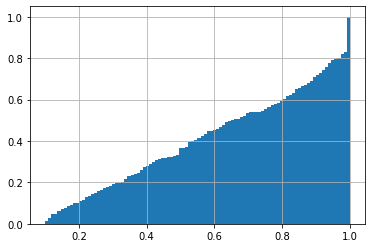

In [115]:
# Compute CDF for jaccard similarity FPS

jac_FP_scores = result_df.loc[(FP) & (result_df['type']=='jaccard') & (result_df.score <= 1.0)].sort_values('score', ascending=False)['score']
jac_FP_scores.hist(cumulative=True, density=1, bins=100)

In [133]:
# Compute CDF for jaccard similarity FPS
wf1_df = result_df.loc[result_df.wf_id == 1]
jac_FP_scores = wf1_df.loc[(FP) & (wf1_df['type']=='containment') & (wf1_df.score <= 1.0)].sort_values('score', ascending=False)['score']
jac_FP_scores.hist(cumulative=True, density=1, bins=100)

KeyError: 'type'

<AxesSubplot:>

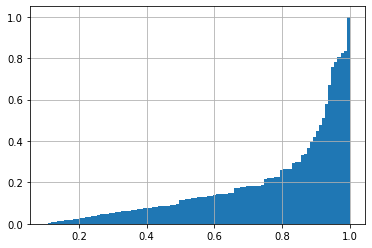

In [118]:
# Compute CDF for jaccard similarity FPS

jac_FP_scores = result_df.loc[(TP) & (result_df['type']=='jaccard') & (result_df.score <= 1.0)].sort_values('score', ascending=False)['score']
jac_FP_scores.hist(cumulative=True, density=1, bins=100)

<AxesSubplot:>

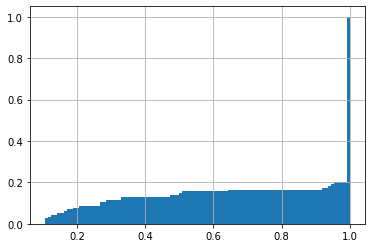

In [120]:
# Compute CDF for jaccard similarity FPS

jac_FP_scores = result_df.loc[(TP) & (result_df['type']=='containment') & (result_df.score <= 1.0)].sort_values('score', ascending=False)['score']
jac_FP_scores.hist(cumulative=True, density=1, bins=100)

In [95]:
result_df.loc[result_df['type'] == 'join']['score'].value_counts()

1.0    3329
Name: score, dtype: int64

In [96]:
ordered_joins = result_df.loc[result_df['type'] == 'join'].sort_values(['wf_id', 'num'])
ordered_joins

,edge,ground_truth,inferred,wf_id,operation,type,score,num
513,"(41_004.csv, 41_003.csv)",True,True,1,sample,join,1.0,538.0
1174,"(22_009.csv, 22_010.csv)",True,True,1,merge,join,1.0,538.0
513,"(65_001.csv, 65_023.csv)",True,False,1,sample,join,1.0,538.0
513,"(3_006.csv, 3_000.csv)",False,True,1,sample,join,1.0,538.0
326,"(9_001.csv, 9_003.csv)",True,True,1,merge,join,1.0,539.0
...,...,...,...,...,...,...,...,...
391,"(76_017.csv, 76_002.csv)",False,True,3,groupby,join,1.0,890.0
439,"(56_019.csv, 56_011.csv)",True,True,3,merge,join,1.0,891.0
1370,"(85_003.csv, 85_002.csv)",True,True,3,merge,join,1.0,891.0
439,"(22_023.csv, 22_025.csv)",True,False,3,merge,join,1.0,891.0


In [72]:
# Find join triple for each edge
#WARNING: not all join edges are correctly numbered: investigate

join_lists = pd.DataFrame(ordered_joins.groupby(['wf_id', 'num']).apply(lambda x: list(frozenset().union(*x['edge']))), columns=['edge_list'])
join_lists['ordered_edge_list'] = join_lists['edge_list'].apply(lambda x: sorted(x, key=lambda y: int(y.split('_')[1].split('.')[0])))

join_lists['list_len'] = join_lists['ordered_edge_list'].apply(lambda x: len(x))
join_lists = join_lists.loc[join_lists.list_len == 3]

join_lists['src1'] = join_lists['ordered_edge_list'].apply(lambda x: x[0])
join_lists['src2'] = join_lists['ordered_edge_list'].apply(lambda x: x[1])
join_lists['dst'] = join_lists['ordered_edge_list'].apply(lambda x: x[2])
join_lists

edge_list  \
wf_id num                                           
1     651.0     [1_022.csv, 1_021.csv, 1_014.csv]   
      652.0  [44_014.csv, 44_013.csv, 44_002.csv]   
      653.0  [93_005.csv, 93_007.csv, 93_008.csv]   
      654.0  [72_016.csv, 72_020.csv, 72_019.csv]   
      655.0  [28_001.csv, 28_002.csv, 28_000.csv]   
...                                           ...   
3     938.0  [12_000.csv, 12_038.csv, 12_037.csv]   
      939.0  [12_034.csv, 12_035.csv, 12_026.csv]   
      940.0  [44_032.csv, 44_034.csv, 44_033.csv]   
      941.0  [64_005.csv, 64_006.csv, 64_000.csv]   
      942.0  [64_001.csv, 64_005.csv, 64_006.csv]   

                                ordered_edge_list  list_len        src1  \
wf_id num                                                                 
1     651.0     [1_014.csv, 1_021.csv, 1_022.csv]         3   1_014.csv   
      652.0  [44_002.csv, 44_013.csv, 44_014.csv]         3  44_002.csv   
      653.0  [93_005.csv, 93_007.csv, 93_008.csv]         3  93_005.csv   
      654.0  [72_016.csv, 72_019.csv, 72_020.csv]         3  72_016.csv   
      655.0  [28_000.csv, 28_001.csv, 28_002.csv]         3  28_000.csv   
...                                           ...       ...         ...   
3     938.0  [12_000.csv, 12_037.csv, 12_038.csv]         3  12_000.csv   
      939.0  [12_026.csv, 12_034.csv, 12_035.csv]         3  12_026.csv   
      940.0  [44_032.csv, 44_033.csv, 44_034.csv]         3  44_032.csv   
      941.0  [64_000.csv, 64_005.csv, 64_006.csv]         3  64_000.csv   
      942.0  [64_001.csv, 64_005.csv, 64_006.csv]         3  64_001.csv   

                   src2         dst  
wf_id num                            
1     651.0   1_021.csv   1_022.csv  
      652.0  44_013.csv  44_014.csv  
      653.0  93_007.csv  93_008.csv  
      654.0  72_019.csv  72_020.csv  
      655.0  28_001.csv  28_002.csv  
...                 ...         ...  
3     938.0  12_037.csv  12_038.csv  
      939.0  12_034.csv  12_035.csv  
      940.0  44_033.csv  44_034.csv  
      941.0  64_005.csv  64_006.csv  
      942.0  64_005.csv  64_006.csv  

[978 rows x 6 columns]

In [74]:
join_lists.groupby(['wf_id','dst']).count()['edge_list'].value_countsnts()

1    856
2     52
3      6
Name: edge_list, dtype: int64

In [131]:
def split_compare(fset):
    x,y = fset
    return x.split('_')[0] != y.split('_')[0]

result_df['cross_workflow'] = result_df['edge'].apply(lambda x: split_compare(x))
result_df.groupby('wf_id').sum()['cross_workflow']

wf_id
1    15
2    62
3     0
4     3
5    62
6     0
Name: cross_workflow, dtype: int64

In [308]:
from relic.utils.pqedge import PQEdges

pqe = PQEdges()

def update_pqe(pqe=None):
    pqe.additem('a',20)

def update(kwargs):
    update_pqe(**kwargs)

update({'pqe': pqe})
pqe

PQEdges({'a': 20})

In [309]:
len(pqe.keys())

1

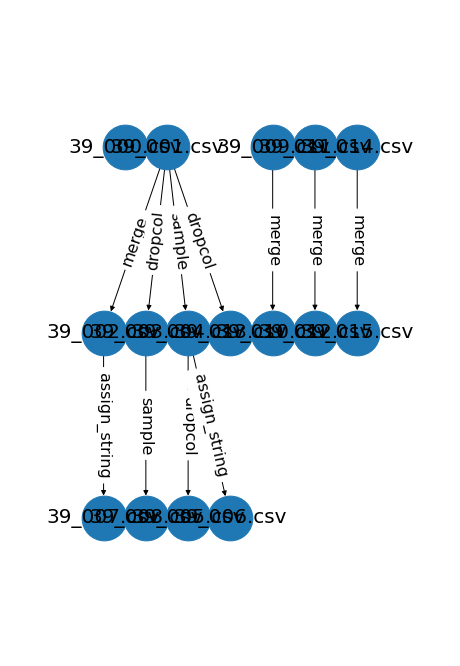

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

In [85]:
sp = 39
sp_graph_file = f"{base_dir}/{1}/graphs/{sp}_gt_fixed.pkl"
sp_gt_graph = nx.read_gpickle(sp_graph_file)
#[c for c in nx.connected_components(sp_gt_graph.to_undirected())]
draw_graph(sp_gt_graph, canvas_Size=(15,15))